# Purpose

Firstly, we need to extract replay errors from the data provided.

On top of the replay errors, we need to extract the data from each map with their:
- LN Ratio
- Difficulty

This will aid in stratifying the results later

As these statistics are per map, we need to have 2 tables that can link.

1) The replay error with bigrams
2) The map statistics

Both linked by the map name.

## Yield Paths

Firstly, let's find the hierarchy of the file paths

In [70]:
import matplotlib.pyplot as plt
import numpy as np

from opal.conf import DATA_DIR

print(f"The data path is {DATA_DIR}")

The data path is E:\Repositories\PycharmProjects\opal\data\osu


We can yield the maps via `load_maps`

In [71]:
from opal.utils import load_maps

loader = load_maps()
df, osu = next(loader)
df2, osu2 = next(loader)
df3, osu3 = next(loader)
meta = osu.metadata(False)
meta2 = osu2.metadata(False)
meta3 = osu3.metadata(False)
dfs = [df, df2, df3]
osus = [osu, osu2, osu3]
metas = [meta, meta2, meta3]

# EDA

Let's perform some EDA on this return!

We have the replay error `df` & osu! map `osu`

## Error

We have 4 types of columns

- `col_x` OHE of if the column is hit
- `is_held_x` OHE of if the column is held
- `diff` difference between the current pattern group and the previous
- `error` player error

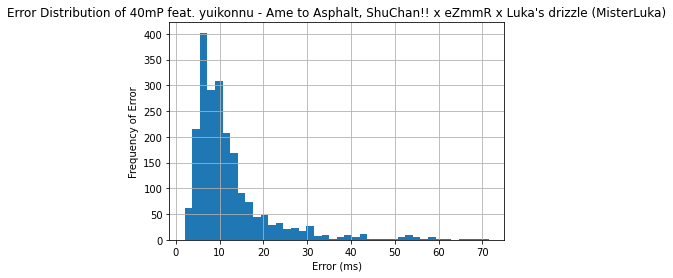

In [72]:
df[['error']].hist(bins=40)
plt.xlabel("Error (ms)")
plt.ylabel("Frequency of Error")
_ = plt.title(f"Error Distribution of {meta}")

## ECDF

One issue with histograms is binning bias, the shape changes w.r.t. its bin size.
**ECDFs** doesn't suffer from it, though it does take some time to understand

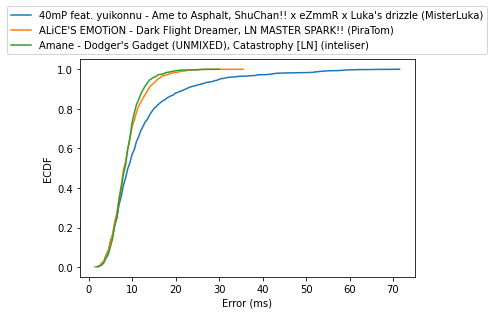

In [73]:
from opal.utils import ecdf

for df_, meta_ in zip(dfs, metas):
    x = ecdf(df_[['error']])
    x.plot(label=meta_)
_ = plt.xlabel("Error (ms)")
_ = plt.ylabel("ECDF")
_ = plt.legend(loc='lower center', bbox_to_anchor=(0.5,1))

### Analysis

We see that the ECDF tells difficulty of the map in multiple dimensions.

The map is harder when:
- the curve is rightwards
- the upper quantile of the curve pitches slower
    - upper quantiles are of larger values


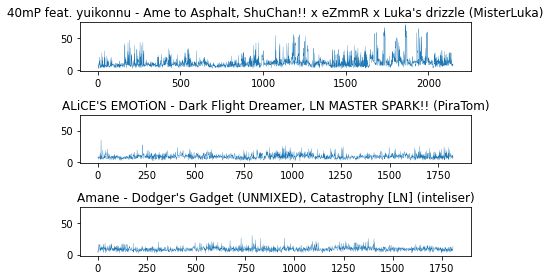

In [74]:
fig, axs = plt.subplots(3, 1, sharey=True)
for ax, df_, meta_ in zip(axs, dfs, metas):
    ax.plot(df_[['error']], linewidth=0.3)
    ax.set_title(meta_)
_ = fig.tight_layout()

In [75]:
qs = np.linspace(0.5, 1, 25)
print("Quantile Error")

for df_, meta_ in zip(dfs, metas):
    print(meta_)
    print(np.quantile(df_['error'], qs).astype(int))


Quantile Error
40mP feat. yuikonnu - Ame to Asphalt, ShuChan!! x eZmmR x Luka's drizzle (MisterLuka)
[ 9  9 10 10 10 11 11 11 12 12 12 13 14 14 15 16 17 18 20 22 24 28 32 43
 71]
ALiCE'S EMOTiON - Dark Flight Dreamer, LN MASTER SPARK!! (PiraTom)
[ 8  8  9  9  9  9  9  9 10 10 10 10 11 11 11 11 12 13 13 14 14 15 16 19
 35]
Amane - Dodger's Gadget (UNMIXED), Catastrophy [LN] (inteliser)
[ 8  9  9  9  9  9  9  9 10 10 10 10 10 10 11 11 11 12 12 12 13 14 15 17
 30]


Using the plot and quantiles, we see that:

- Ame to Asphalt is hardest
- Dark Flight Dreamer has similar difficulty to Dodger's Gadget

### Summary of Error ECDF

We see that ECDF is a simple way to discern difficulty of a map, however, let's take a look at ECDFs of more maps

196it [00:02, 81.61it/s]


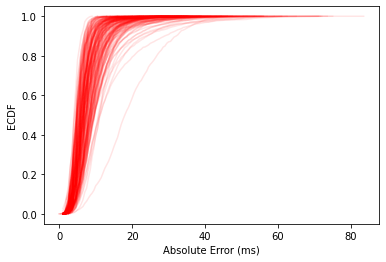

In [76]:
from tqdm import tqdm
for df_, osu_ in tqdm(load_maps(False)):
    x = ecdf(df_[['error']])
    meta_ = osu.metadata(False)
    x.plot(color='red', alpha=0.1)
_ = plt.xlabel("Absolute Error (ms)")
_ = plt.ylabel("ECDF")

We see performances of consistent shapes, with a few outliers, let's further separate them by taking its cube root

196it [00:02, 74.80it/s]


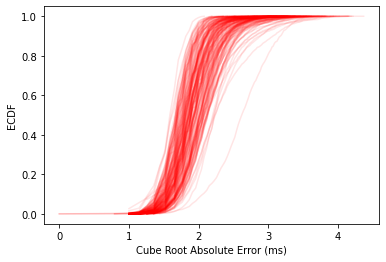

In [77]:
for df_, osu_ in tqdm(load_maps(False)):
    x = ecdf(df_[['error']] ** (1 / 3))
    x.plot(color='red', alpha=0.1)
_ = plt.xlabel("Cube Root Absolute Error (ms)")
_ = plt.ylabel("ECDF")

We see a spaghetti of lines in the middle, consider the following:

- If we take a specific **ECDF = x**, a horizontal line, we have an order of maps.
- Maps further to the right (larger error) are more difficult, vice versa.
- If with more trials with different x, that agrees that Map A > B, we find more confidence that Map A > B.

We can aggregate this by doing a rank sum

In [78]:
# Let's firstly yield the quantiles from 0.1 to 0.9 for the maps
qs_bin = np.linspace(0.1, 0.9, 9)
ar_qs = []
for df_, meta_ in zip(dfs, metas):
    ar_qs.append (np.quantile(df_[['error']], qs_bin))

ar_qs = np.asarray(ar_qs)

In [79]:
# Then we use scipy stats to rank the data
# Same values are ranked the same
import pandas as pd
from scipy.stats import rankdata
srs = pd.Series(rankdata(ar_qs,axis=0).sum(axis=1), index=metas, name="weight")
srs

40mP feat. yuikonnu - Ame to Asphalt, ShuChan!! x eZmmR x Luka's drizzle (MisterLuka)    23.5
ALiCE'S EMOTiON - Dark Flight Dreamer, LN MASTER SPARK!! (PiraTom)                       15.5
Amane - Dodger's Gadget (UNMIXED), Catastrophy [LN] (inteliser)                          15.0
Name: weight, dtype: float64

The results are consistent with what we found, Ame to Asphalt is heavily favored to be the hardest.
Followed by the next 2 which are closely weighted.

Let's take a look at more maps, see if they are consistent

In [80]:
# Let's firstly yield the quantiles from 0.1 to 0.9 for the maps
ar_qs = []
metas_ = []
for df_, osu_ in tqdm(load_maps()):
    metas_.append(osu_.metadata(False))
    ar_qs.append(np.quantile(df_[['error']], qs_bin))

ar_qs = np.asarray(ar_qs)
# Then we use scipy stats to rank the data
# Same values are ranked the same
import pandas as pd
from scipy.stats import rankdata

srs = pd.Series(rankdata(ar_qs, axis=0).sum(axis=1), index=metas_, name="weight")
srs.sort_values(ascending=False)

196it [00:00, 414.74it/s]


ueotan - Mario Paint (Time Regression Mix for BMS), D-ANOTHER (Fullerene-)                   1764.0
Camellia - Kamah (Scythe), Set them free (Ticle)                                             1744.0
Suzuki Konomi - One Day Sky, The Final ShuChan!! (shuniki)                                   1738.0
Kommisar - Southern Waters Assault 8bit, LN Master (Gekido-)                                 1726.5
Camellia - Kamah (Scythe), Bringo's Insane (Ticle)                                           1724.0
                                                                                              ...  
MasamiT - Trouble Kuroneko Man'yuuki, Ayumu's Distress (AutotelicBrown)                        94.5
Seiryu - AO-INFINITY, Autumn (Tailsdk)                                                         79.0
Yuuna Sasara feat. Tai no Kobone - Imperishable Night 2006, 4K PROGUY's Normal (xxbidiao)      40.0
Caravan Palace - Lone Digger, Jack Digger (XeoStyle)                                           24.0


We see an obvious problem here, because by sorting, we eliminate the absolute difference between maps.
Mario Paint is miles harder than many others, but it's rated higher only slightly.

Take a look at the ECDF of the 80% Quantile. It's similar to a Normal Distribution

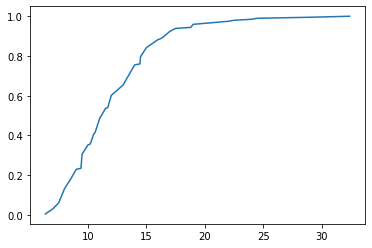

In [81]:
_ = ecdf(pd.Series(ar_qs[:,8])).plot()

The idea is to approximate this normal distribution, and use stdev as weight instead

In [82]:
from sklearn.preprocessing import scale

x = scale(ar_qs, axis=0)
# Assert that std is 1
print(np.std(x[:,0]))
# Assert that mean is 0
print(np.mean(x[:,0]))

1.0000000000000004
-6.072240216317183e-16


In [83]:
srs = pd.Series(x.sum(axis=1), index=metas_, name="weight")
srs.sort_values(ascending=False)

ueotan - Mario Paint (Time Regression Mix for BMS), D-ANOTHER (Fullerene-)                   53.480893
Suzuki Konomi - One Day Sky, The Final ShuChan!! (shuniki)                                   24.303028
Camellia - Kamah (Scythe), Set them free (Ticle)                                             23.129266
MasamiT - Trouble Kuroneko Man'yuuki, Ayumu's Trouble 1.4x (AutotelicBrown)                  20.487248
Kommisar - Southern Waters Assault 8bit, LN Master (Gekido-)                                 19.920157
                                                                                               ...    
MasamiT - Trouble Kuroneko Man'yuuki, Ayumu's Distress (AutotelicBrown)                     -11.879475
Seiryu - AO-INFINITY, Autumn (Tailsdk)                                                      -12.267582
Yuuna Sasara feat. Tai no Kobone - Imperishable Night 2006, 4K PROGUY's Normal (xxbidiao)   -13.671309
Caravan Palace - Lone Digger, Jack Digger (XeoStyle)                     

## Summary of ECDF Quantile Sorting

This looks great! However, we see some anomalies.

Set them free is hard, but not **that hard**.
We see a clear anomalous trend here: LN maps are overrated.